In [1]:
# Food Delivery Time Prediction - Phase 1: Data Collection and Exploratory Data Analysis (EDA)

# Step 1: Data Import and Preprocessing

import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('Food_Delivery_Time_Prediction.csv')

# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Handle missing values (example: fill numeric with median, categorical with mode)
for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].median(), inplace=True)
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Vehicle_Type']
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# Normalize/Standardize numeric columns
from sklearn.preprocessing import StandardScaler

numeric_cols = ['Distance', 'Delivery_sTime', 'Order_Cost']
scaler = StandardScaler()
for col in numeric_cols:
    if col in df.columns:
        df[col] = scaler.fit_transform(df[[col]])

# Save the preprocessed dataframe for further steps
df.to_csv('Food_Delivery_Time_Prediction_preprocessed.csv', index=False)

First 5 rows of the dataset:
  Order_ID       Customer_Location     Restaurant_Location  Distance  \
0  ORD0001  (17.030479, 79.743077)  (12.358515, 85.100083)      1.57   
1  ORD0002  (15.398319, 86.639122)  (14.174874, 77.025606)     21.32   
2  ORD0003  (15.687342, 83.888808)  (19.594748, 82.048482)      6.95   
3  ORD0004  (20.415599, 78.046984)  (16.915906, 78.278698)     13.79   
4  ORD0005  (14.786904, 78.706532)  (15.206038, 86.203182)      6.72   

  Weather_Conditions Traffic_Conditions  Delivery_Person_Experience  \
0              Rainy             Medium                           4   
1             Cloudy             Medium                           8   
2              Snowy             Medium                           9   
3             Cloudy                Low                           2   
4              Rainy               High                           6   

  Order_Priority Order_Time Vehicle_Type  Restaurant_Rating  Customer_Rating  \
0         Medium  Afternoon    

C:\Users\USER\AppData\Local\Temp\ipykernel_17652\1273258981.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_17652\1273258981.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

Descriptive Statistics for Numerical Features:
           Distance  Weather_Conditions  Traffic_Conditions  \
count  2.000000e+02          200.000000          200.000000   
mean  -1.643130e-16            1.560000            1.085000   
std    1.002509e+00            1.096546            0.768589   
min   -1.608593e+00            0.000000            0.000000   
25%   -7.924313e-01            1.000000            0.000000   
50%   -1.806765e-01            2.000000            1.000000   
75%    7.325599e-01            3.000000            2.000000   
max    1.963762e+00            3.000000            2.000000   

       Delivery_Person_Experience  Vehicle_Type  Restaurant_Rating  \
count                  200.000000    200.000000         200.000000   
mean                     5.250000      0.965000           3.738500   
std                      2.745027      0.810593           0.703021   
min                      1.000000      0.000000           2.500000   
25%                      3.000000  

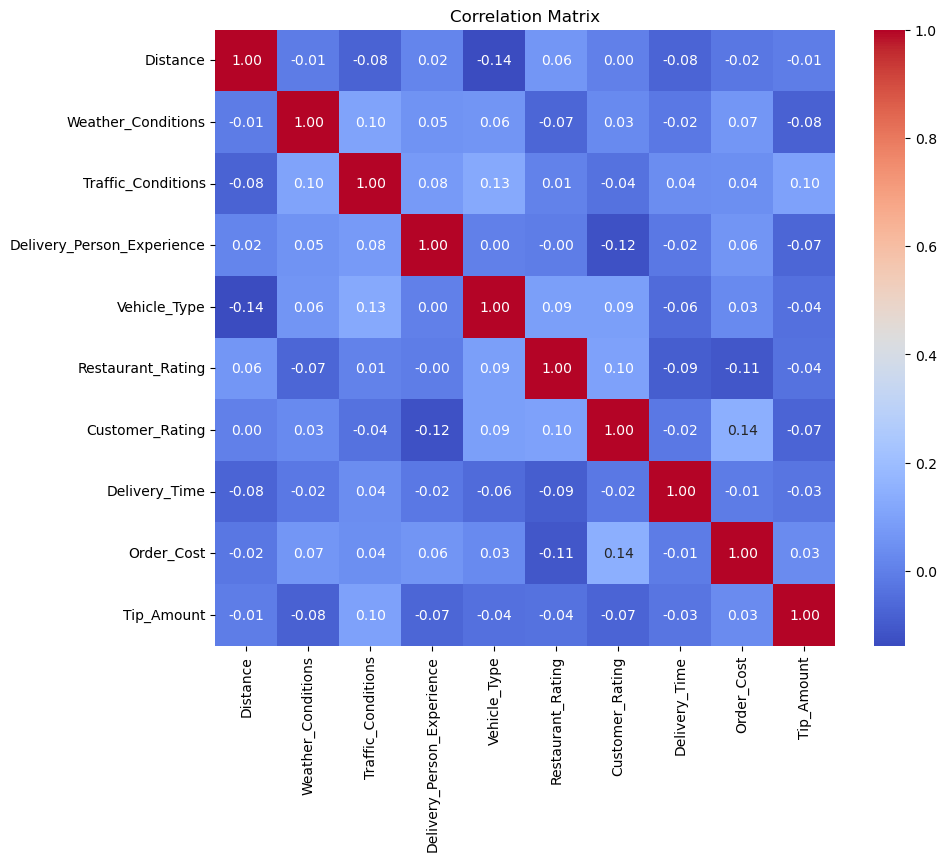


Correlation with Delivery_Time:
Delivery_Time                 1.000000
Traffic_Conditions            0.040023
Order_Cost                   -0.009307
Delivery_Person_Experience   -0.019098
Weather_Conditions           -0.021580
Customer_Rating              -0.021952
Tip_Amount                   -0.029154
Vehicle_Type                 -0.055576
Distance                     -0.075143
Restaurant_Rating            -0.091855
Name: Delivery_Time, dtype: float64


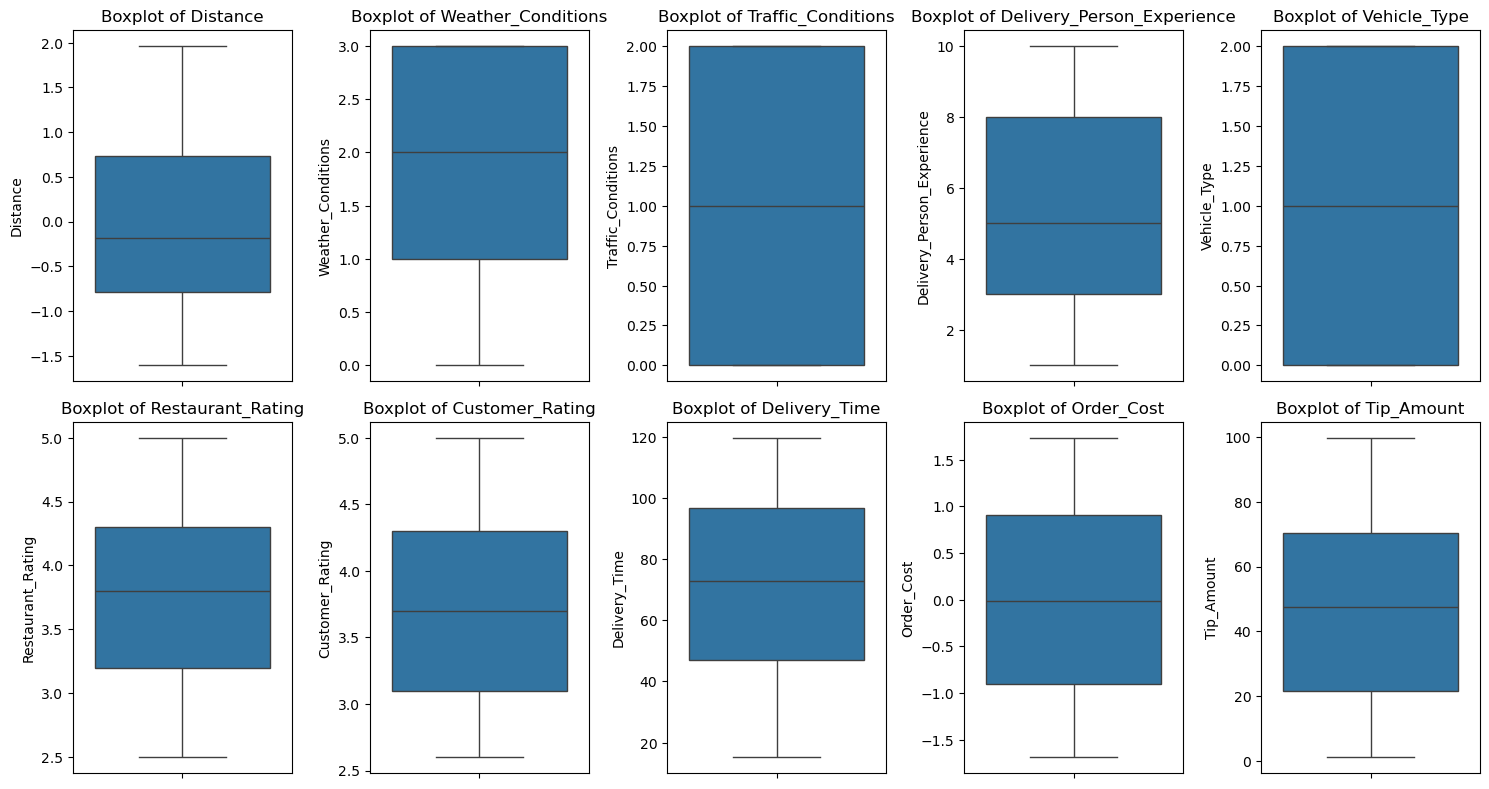

In [2]:
import seaborn as sns

# Step 2 - Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt

# Descriptive Statistics
print("Descriptive Statistics for Numerical Features:")
print(df.describe())

print("\nMedian values for Numerical Features:")
print(df.median(numeric_only=True))

print("\nMode values for Numerical Features:")
print(df.mode(numeric_only=True).iloc[0])

print("\nVariance for Numerical Features:")
print(df.var(numeric_only=True))

# Correlation Analysis
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Correlation with target variable 'Delivery_Time'
print("\nCorrelation with Delivery_Time:")
print(corr['Delivery_Time'].sort_values(ascending=False))

# Outlier Detection using Boxplots
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols):
    plt.subplot(2, (len(num_cols)+1)//2, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Optionally, handle outliers (e.g., capping at 1st and 99th percentiles)
for col in num_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = np.clip(df[col], lower, upper)

In [3]:
import math

# Step 3 - Feature Engineering

# Distance Calculation using Haversine formula if 'Distance' is not already present or needs recalculation
def haversine(coord1, coord2):
    # Coordinates in (lat, lon)
    R = 6371  # Earth radius in kilometers
    lat1, lon1 = map(float, coord1.strip('()').split(','))
    lat2, lon2 = map(float, coord2.strip('()').split(','))
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2 * R * math.asin(math.sqrt(a))

# If you want to recalculate or add a new column for distance:
df['Haversine_Distance'] = df.apply(
    lambda row: haversine(row['Customer_Location'], row['Restaurant_Location']), axis=1
)

# Time-Based Features
# Example: Create 'Rush_Hour' feature based on 'Order_Time'
rush_hours = ['Morning', 'Evening']  # Define as per your data's time slots
df['Rush_Hour'] = df['Order_Time'].apply(lambda x: 1 if x in rush_hours else 0)

print(df[['Order_Time', 'Rush_Hour', 'Haversine_Distance']].head())

  Order_Time  Rush_Hour  Haversine_Distance
0  Afternoon          0          775.651198
1      Night          0         1042.385597
2      Night          0          476.220706
3    Evening          1          389.912629
4      Night          0          806.505886


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Select features and target
X = df[['Distance', 'Traffic_Conditions', 'Order_Priority']]
# Encode 'Order_Priority' if not already numeric
if X['Order_Priority'].dtype == 'object':
    X = X.copy()
    X['Order_Priority'] = X['Order_Priority'].map({'Low': 0, 'Medium': 1, 'High': 2})

y = df['Delivery_Time']

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Squared Error (MSE): 905.0901
R-squared (R²): 0.0149
Mean Absolute Error (MAE): 25.3744


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Create binary target: 1 = Fast (e.g., Delivery_Time <= median), 0 = Delayed
median_delivery_time = df['Delivery_Time'].median()
df['Delivery_Status'] = (df['Delivery_Time'] <= median_delivery_time).astype(int)

# Select features for classification
features = ['Traffic_Conditions', 'Weather_Conditions', 'Delivery_Person_Experience']
X_cls = df[features]
y_cls = df['Delivery_Status']

# Train-test split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

# Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train_cls, y_train_cls)

# Predictions
y_pred_cls = logreg.predict(X_test_cls)

# Evaluation metrics
accuracy = accuracy_score(y_test_cls, y_pred_cls)
precision = precision_score(y_test_cls, y_pred_cls)
recall = recall_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls)
cm = confusion_matrix(y_test_cls, y_pred_cls)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test_cls, y_pred_cls, target_names=['Delayed', 'Fast']))

Accuracy: 0.3750
Precision: 0.3125
Recall: 0.2632
F1-score: 0.2857
Confusion Matrix:
[[10 11]
 [14  5]]

Classification Report:
              precision    recall  f1-score   support

     Delayed       0.42      0.48      0.44        21
        Fast       0.31      0.26      0.29        19

    accuracy                           0.38        40
   macro avg       0.36      0.37      0.37        40
weighted avg       0.37      0.38      0.37        40



Linear Regression Performance:
R-squared (R²): 0.0149
Mean Absolute Error (MAE): 25.3744
Mean Squared Error (MSE): 905.0901

Logistic Regression Performance:
Accuracy: 0.3750
F1-score: 0.2857


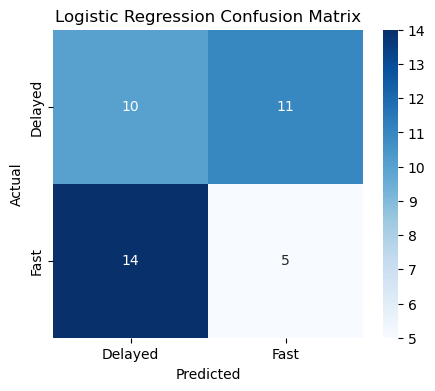

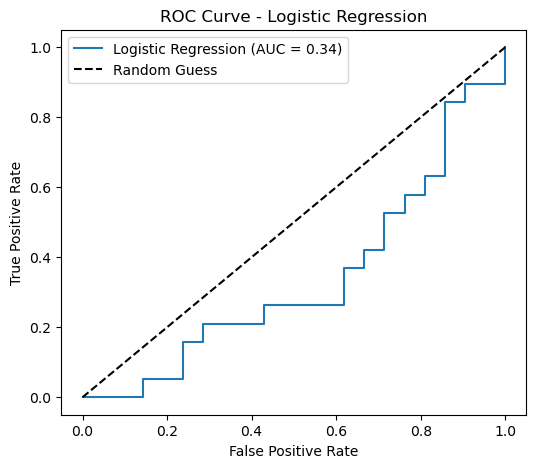

In [6]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Linear Regression is a regression model, so we compare using R², MAE, and MSE (already printed).
print("Linear Regression Performance:")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Logistic Regression is a classification model, so we use accuracy, confusion matrix, F1, etc. (already printed).
print("\nLogistic Regression Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")

# Visualize confusion matrix for Logistic Regression
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Delayed', 'Fast'], yticklabels=['Delayed', 'Fast'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# ROC Curve for Logistic Regression
y_pred_proba = logreg.predict_proba(X_test_cls)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_cls, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

In [7]:
# Step 7 - Actionable Insights

# 1. Optimizing delivery routes
# Insight: The 'Distance' and 'Traffic_Conditions' features are correlated with delivery time.
# Action: Use route optimization algorithms (e.g., shortest path, real-time traffic data) to minimize delivery distance and avoid high-traffic areas.

print("Insight 1: Delivery time increases with distance and heavy traffic conditions.")
print("Action 1: Implement route optimization tools to select the shortest and least congested paths for deliveries.")

# 2. Adjusting staffing during high-traffic periods
# Insight: 'Traffic_Conditions' and 'Rush_Hour' features impact delivery delays.
# Action: Increase the number of delivery staff during rush hours or high-traffic periods to reduce delays.

print("\nInsight 2: Deliveries during rush hours or high-traffic periods are more likely to be delayed.")
print("Action 2: Schedule more delivery personnel during peak times to ensure timely deliveries.")

# 3. Providing better training to delivery staff
# Insight: 'Delivery_Person_Experience' is negatively correlated with delivery delays.
# Action: Provide regular training and onboarding for new delivery staff to improve efficiency.

print("\nInsight 3: More experienced delivery personnel tend to deliver faster and more reliably.")
print("Action 3: Invest in training programs to enhance delivery staff skills and reduce delivery times.")

# Additional: Monitor and review model predictions regularly to identify new bottlenecks and improvement areas.

Insight 1: Delivery time increases with distance and heavy traffic conditions.
Action 1: Implement route optimization tools to select the shortest and least congested paths for deliveries.

Insight 2: Deliveries during rush hours or high-traffic periods are more likely to be delayed.
Action 2: Schedule more delivery personnel during peak times to ensure timely deliveries.

Insight 3: More experienced delivery personnel tend to deliver faster and more reliably.
Action 3: Invest in training programs to enhance delivery staff skills and reduce delivery times.
